In [1]:
import jax
import numpyro
import blackjax
import numpy as np
import jax.numpy as jnp
import numpyro.distributions as dist
from numpyro.infer.util import initialize_model
from numpyro.infer.reparam import LocScaleReparam
from numpyro.handlers import reparam
from numpyro.infer.reparam import TransformReparam
import matplotlib.pyplot as plt

/Users/madhav/anaconda3/envs/experiment/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Model initialization values
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

In [3]:
def eight_schools():
    mu = numpyro.sample('mu', dist.Normal(2, 5))
    tau = numpyro.sample('tau', dist.HalfCauchy(5))
    theta = numpyro.sample('theta', dist.Normal(jnp.full(J,mu), tau))
    numpyro.sample('obs', dist.Normal(theta, sigma), obs=y)

In [4]:
rng_key = jax.random.PRNGKey(0)

In [5]:
num_warmup = 500

adapt = blackjax.window_adaptation(
    blackjax.nuts, eight_schools, target_acceptance_rate=0.8
)
(last_state, parameters), intermediate_states, logdensity_fn = adapt.run(rng_key, num_warmup)

Centeredness:  [6.8036411e-03 5.5321403e-02 3.3690915e-03 1.4231724e-05 1.8844408e-01
 2.0367986e-01 2.6264443e-04 1.2288201e-01]
Previous Centeredness:  [1. 1. 1. 1. 1. 1. 1. 1.]
Varname:  theta
samples {'mu': [10.044331550598145, 4.327369689941406, 12.419803619384766, 4.643599033355713, 4.21378755569458, -0.8658630847930908, 1.1713621616363525, -0.501419723033905, -0.26115739345550537, 3.3210370540618896, 3.550549268722534, 3.417045831680298, 5.855690956115723, 7.801980495452881, 8.373491287231445, 2.805680513381958, 9.302342414855957, 7.090766906738281, 7.07479190826416, 6.055692195892334, 3.535170793533325, 3.019336223602295, 3.9012134075164795, 4.479172706604004, 5.008868217468262], 'tau': [2.2007079124450684, 2.3120806217193604, 2.106557607650757, 1.910295009613037, 2.175809621810913, 1.1650947332382202, 1.4813941717147827, 0.8407694101333618, 1.2379082441329956, 1.2340278625488281, 1.9939899444580078, 1.7090586423873901, 2.4414265155792236, 2.2133662700653076, 1.2301188707351685

In [6]:
kernel = blackjax.nuts(logdensity_fn, **parameters).step

In [7]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, info = kernel(rng_key, state)
        return state, (state, info)

    keys = jax.random.split(rng_key, num_samples)
    extra, (states, infos) = jax.lax.scan(one_step, initial_state, keys)

    return states, (
        infos.acceptance_rate,
        infos.is_divergent,
        infos.num_integration_steps,
    )

In [8]:
num_sample = 1000

states, infos = inference_loop(rng_key, kernel, last_state, num_sample)
_ = states.position["mu"].block_until_ready()

In [9]:
def scatterplt(samples):
    fig, axes = plt.subplots(4, 2, figsize=(10, 12))
    axes = axes.flatten()
    # reparam_sample, mvn, mu_theta, std_theta = reparameterize_samples_dist(samples, best_c)
    # reparam_sample = reparam_sample if reparam else samples['theta'].T
    samples_theta = samples['theta'].T
    for i in range(8):
        axes[i].scatter(samples_theta[i], samples['tau'])
        axes[i].set_xlabel(f'theta_{i}')
        axes[i].set_ylabel('log_std')

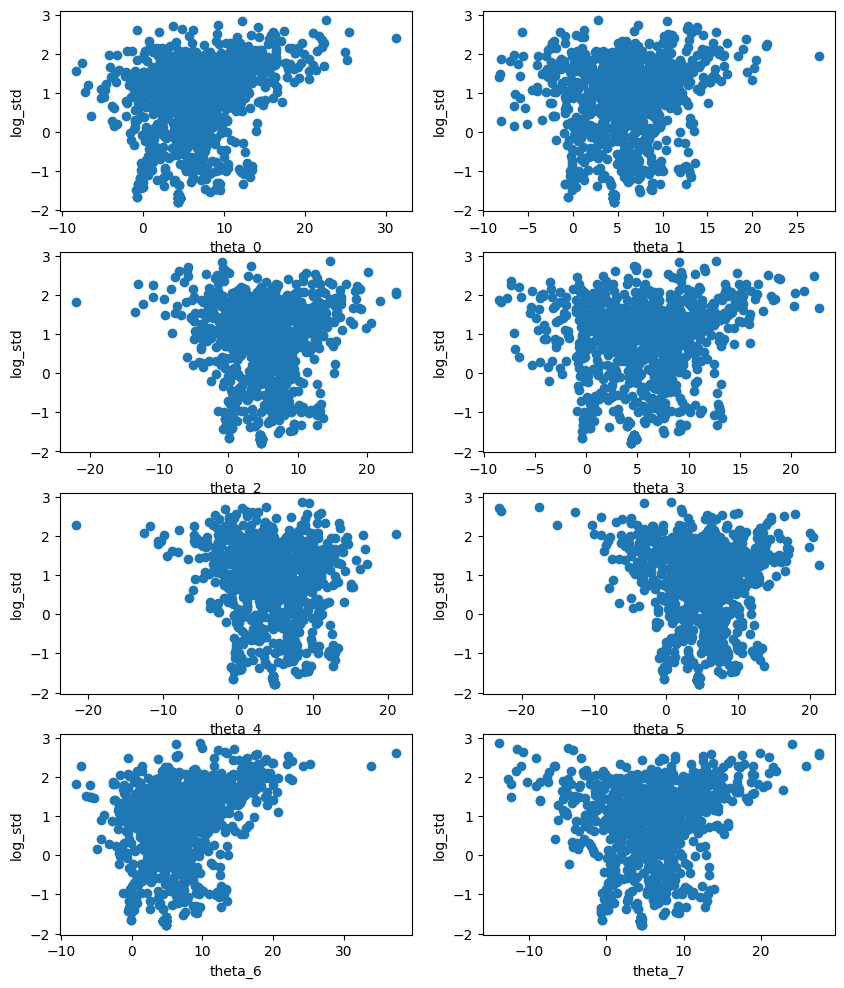

In [10]:
scatterplt(states[0])

In [11]:
acceptance_rate = np.mean(infos[0])
num_divergent = np.mean(infos[1])

print(f"\Average acceptance rate: {acceptance_rate:.2f}")
print(f"There were {100*num_divergent:.2f}% divergent transitions")

\Average acceptance rate: 0.91
There were 1.30% divergent transitions


In [12]:
raise ValueError("This is a custom value error.")

ValueError: This is a custom value error.

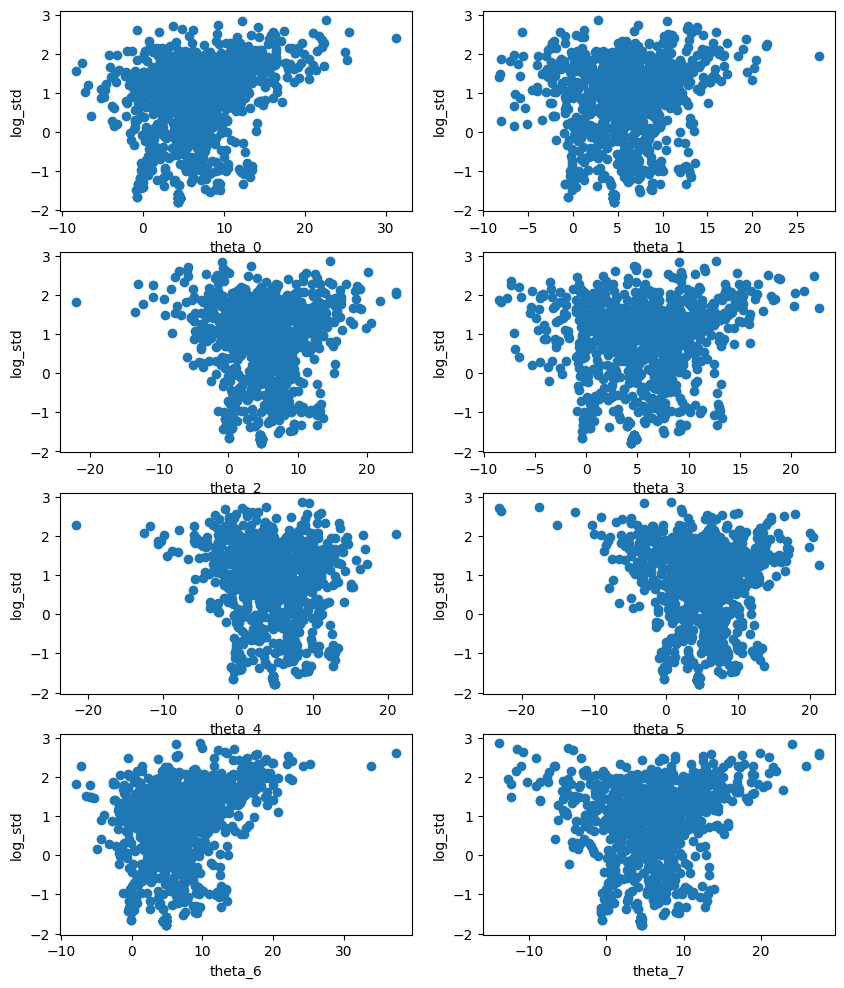

In [ ]:
scatterplt(states[0])

In [ ]:
acceptance_rate = np.mean(infos[0])
num_divergent = np.mean(infos[1])

print(f"\Average acceptance rate: {acceptance_rate:.2f}")
print(f"There were {100*num_divergent:.2f}% divergent transitions")

\Average acceptance rate: 0.86
There were 0.10% divergent transitions
